In [ ]:
# import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Humber AI ML/AIGC5502 - Image Processing CV/Week 8/Assign05/Assign05

/content/drive/MyDrive/Humber AI ML/AIGC5502 - Image Processing CV/Week 8/Assign05/Assign05


# HAR Images Dataset

Let's see a sample of the images in the dataset.

3 classes:
['Catch', 'Clap', 'Hammering']


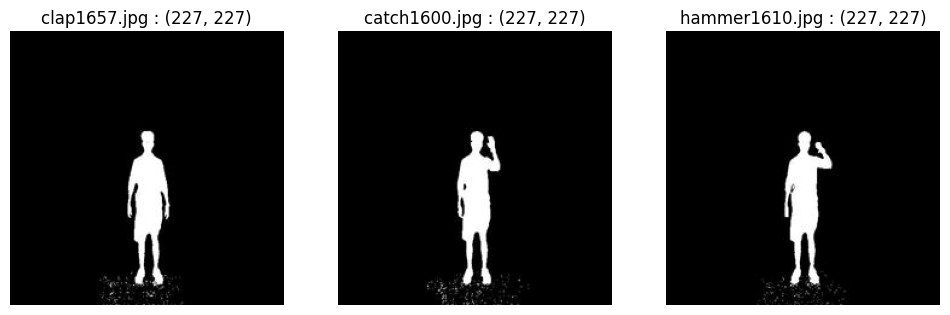

In [ ]:
data_path = 'HAR_Images'
# Get the class names
classes = os.listdir(data_path)
classes.sort()
print(len(classes), 'classes:')
print(classes)

# Show the first image in each folder
fig = plt.figure(figsize=(12, 12))
i = 0
for sub_dir in os.listdir(data_path):
    i+=1
    img_file = os.listdir(os.path.join(data_path,sub_dir))[0]
    img_path = os.path.join(data_path, sub_dir, img_file)
    img = io.imread(img_path, as_gray=True)
    img_shape = np.array(img).shape
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img, cmap='gray')
    a.set_title(img_file + ' : ' + str(img_shape))
plt.show()

The images are 227x227 in shape.

# Importing the Dataset

In [ ]:
# Reading the data
images = []
labels = []
for sub_dir in os.listdir(data_path):
    img_dir = os.listdir(os.path.join(data_path,sub_dir))
    for img in img_dir:
        imgpath = os.path.join(data_path, sub_dir, img)
        images.append(io.imread(imgpath, as_gray=True).flatten())
        labels.append(sub_dir)
images = np.array(images)
labels = np.array(labels)

In [ ]:
# Encoding the labels
le = LabelEncoder()
labels = le.fit_transform(labels)
mapping = dict(zip(le.classes_, range(len(le.classes_))))
mapping

{'Catch': 0, 'Clap': 1, 'Hammering': 2}

# Create train/test groups using DataLoader

In [ ]:
# Step 1: convert to tensor
dataT   = torch.tensor(images).float()
labelsT = torch.tensor(labels).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1, random_state=0)
print('Train size:', len(train_labels))
print('Test size:', len(test_labels))

# Step 3: standardize the data
max = torch.max(train_data)
train_data = train_data/max
test_data  = test_data/max

# Step 4: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 5: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

Train size: 4552
Test size: 506


In [ ]:
for X,y in train_loader:
  print(X.shape)
  break

torch.Size([32, 51529])


# Creating the ANN Model

In [ ]:
class ann(nn.Module):
  def __init__(self, ninp, nhid1, nhid2, nhid3, nout):
    nn.Module.__init__(self) # Constructor for base class of NN in PyTorch
    # Define the layers
    self.linear1 = nn.Linear(ninp, nhid1)
    self.linear2 = nn.Linear(nhid1, nhid2)
    self.linear3 = nn.Linear(nhid2, nhid3)
    self.linear4 = nn.Linear(nhid3, nout)
    self.lsmax = nn.LogSoftmax(dim=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)
    x = self.relu(x)
    x = self.linear3(x)
    x = self.relu(x)
    out = self.linear4(x)
    return self.lsmax(out)    # Log Softmax

In [ ]:
# ANN model
model =  ann(ninp=51529, nhid1=128, nhid2=64, nhid3=32, nout=3)

# Number of epochs
epochs = 101

# Define CrossEntropy loss function
lossfunc = nn.CrossEntropyLoss()

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters())

model.to(device) # placing a model on GPU

# initialize losses
losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []

# loop over epochs
for epochi in range(epochs):
 model.train()
 # loop over training data batches
 batchAcc  = []
 batchLoss = []
 for X,y in train_loader:

  # New!
  X = X.to(device)
  y = y.to(device)

  # forward pass and loss

  ypred = model(X)
  loss = lossfunc(ypred,y)

  # backprop

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # loss from this batch
  batchLoss.append(loss.item())

  # New! bring outputs back to cpu

  ypred = ypred.cpu()
  y = y.cpu()

  # compute accuracy
  batchAcc.append((100*torch.mean((torch.argmax(ypred,dim=1)==y).float())))
# end of batch loop...

# now that we've trained through the batches, get their average training accuracy
 trainAcc.append( np.mean(batchAcc) )

# and get average losses across the batches
 losses[epochi] = np.mean(batchLoss)

# test accuracy
 model.eval()
 X,y = next(iter(test_loader)) # extract X,y from test dataloader

# New!
 X = X.to(device)
 y = y.to(device)

 with torch.no_grad(): # deactivates autograd
  ypred = model(X)

# New! bring outputs back
  ypred = ypred.cpu()
  y = y.cpu()

# compare the following really long line of code to the training accuracy lines
  testAcc.append( 100*torch.mean((torch.argmax(ypred,dim=1)==y).float()) )
  if (epochi % 10) == 0:
    print(f' epochs : {epochi},  loss : {loss}, test accuracy: {testAcc[-1]}')

 epochs : 0,  loss : 0.27322062849998474, test accuracy: 93.67588806152344
 epochs : 10,  loss : 0.0006206067046150565, test accuracy: 99.8023681640625
 epochs : 20,  loss : 6.048088471288793e-05, test accuracy: 99.8023681640625
 epochs : 30,  loss : 2.6964840799337253e-05, test accuracy: 99.8023681640625
 epochs : 40,  loss : 7.674075277463999e-07, test accuracy: 99.8023681640625
 epochs : 50,  loss : 7.338786076616088e-07, test accuracy: 99.8023681640625
 epochs : 60,  loss : 1.5646209305941738e-07, test accuracy: 99.8023681640625
 epochs : 70,  loss : 1.7881363589822286e-07, test accuracy: 99.8023681640625
 epochs : 80,  loss : 1.3783549945856066e-07, test accuracy: 99.8023681640625
 epochs : 90,  loss : 8.195630840646118e-08, test accuracy: 99.8023681640625
 epochs : 100,  loss : 1.4901125666710868e-07, test accuracy: 99.8023681640625


# Visualizing Loss and Accuracy

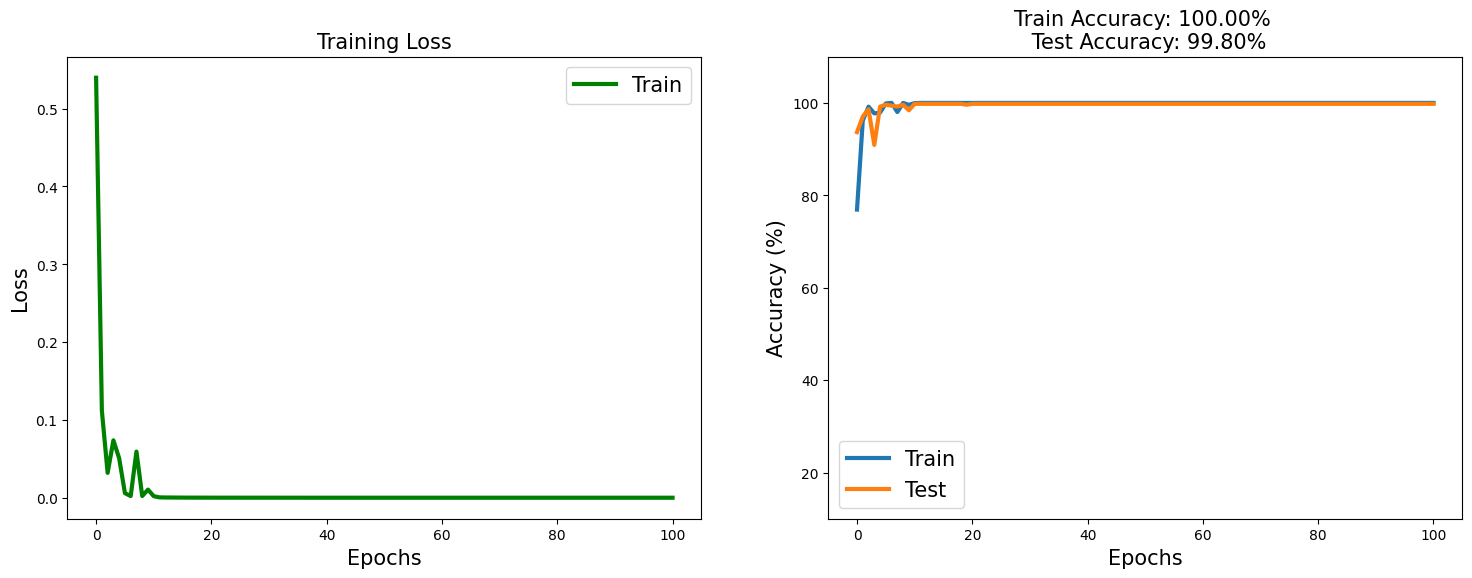

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()

Learning appears to stabilize after approximately 10 epochs.